# Data loading
First of all we exported the data from the excel file and saved it as a csv file.
Then we formatted the data to be easily compatible with pandas.
We did so by using the following commands in the vim editor:
```vim
:%s/\.//g
:%s/,/./g
:wq
```

In [2]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from arch import arch_model

# load the data from the csv file, setting the date column as the index
df = pd.read_csv('InvestmentReplica.csv', delimiter=';')
# convert the date column to datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)
# extract the indexes
indexes = ['HFRXGL', 'LEGATRUU', 'MXWD', 'MXWO']
indexes = df[indexes]

# extract the futures
futures = ['CO1','DU1','ES1','GC1','LLL1','NQ1','RX1','TP1','TU2','TY1','VG1']
futures = df[futures]

# Data Exploration
## Target data exploration
Let us plot the graphs of the indexes of the data to see how they are distributed.

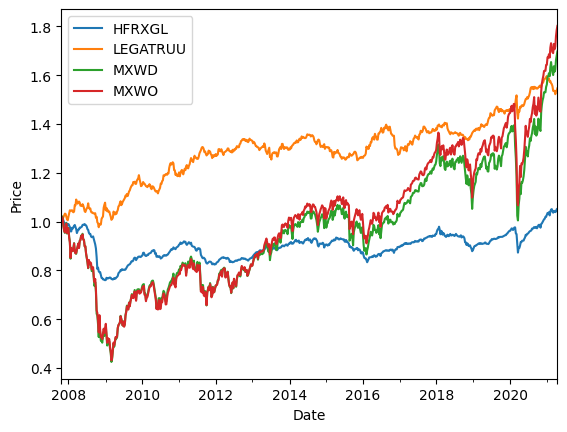

In [3]:
# graph the indexes normalized to the first value
indexes_plot = indexes.div(indexes.iloc[0]).plot()
indexes_plot.set_xlabel('Date')
indexes_plot.set_ylabel('Price')
indexes_plot.legend(loc='upper left')
plt.show()

# Target portfolio selection
We create the target portfolio as the minimum variance portfolio of the four
indexes with the a fixed return of 10%.
We do so by using the following weights:

$$ w_i = \frac{{\Sigma^{-1} \left( \mu - r \cdot \mathbf{1} \right)}}
{\mathbf{1}^T \cdot \Sigma^{-1} \left( \mu - r \cdot \mathbf{1} \right)}
$$

where $\Sigma$ is the covariance matrix and $\mu$ is the vector of expected returns and r is the fixed return we want to achieve.

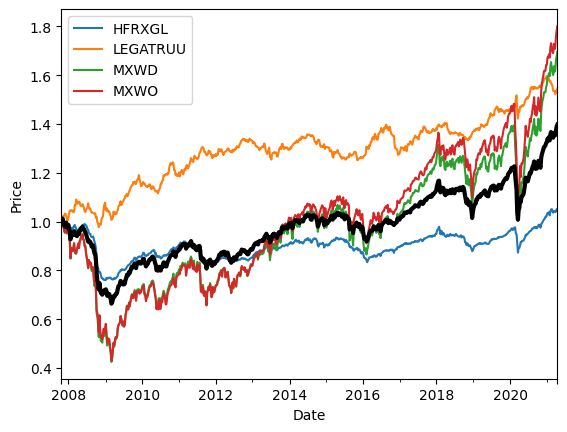


Minimum Variance Portfolio:
Weights: [ 0.62243121  0.43610554 -0.56706528  0.50852854]
Expected Return: 0.9826215932250159
Standard Deviation: 0.14086125906583136



In [4]:
# Define the expected returns, covariance matrix, and fixed return
expected_returns = indexes.pct_change().mean()
covariance_matrix = indexes.pct_change().cov()
covariance_inverse = np.linalg.inv(covariance_matrix)
ones = np.ones(len(expected_returns))
fixed_return = 0.1  
# Calculate the numerator and denominator of the weight formula
numerator = covariance_inverse @ (expected_returns - ones * fixed_return)
denominator = ones @ covariance_inverse @ (expected_returns - ones * fixed_return)
# Calculate the weights of the minimum variance portfolio for the fixed return
weights = numerator / denominator
target = indexes.dot(weights)
target.name = 'Target'

# graph the indexes normalized to the first value and the minimum variance portfolio
indexes_plot = indexes.div(indexes.iloc[0]).plot()
indexes_plot.set_xlabel('Date')
indexes_plot.set_ylabel('Price')
indexes_plot.legend(loc='upper left')
target_plot = target.div(target.iloc[0]).plot(lw=3, color='black', label='Target', ax=indexes_plot)
target_plot.set_xlabel('Date')
plt.show()

# show the weights of the minimum variance portfolio, the expected return and
# the standard deviation
print(f"""
Minimum Variance Portfolio:
Weights: {weights}
Expected Return: {target.div(target.iloc[0]).mean()}
Standard Deviation: {target.div(target.iloc[0]).std()}
""")

### Stationarity test

The time series is not stationary
The time series is stationary


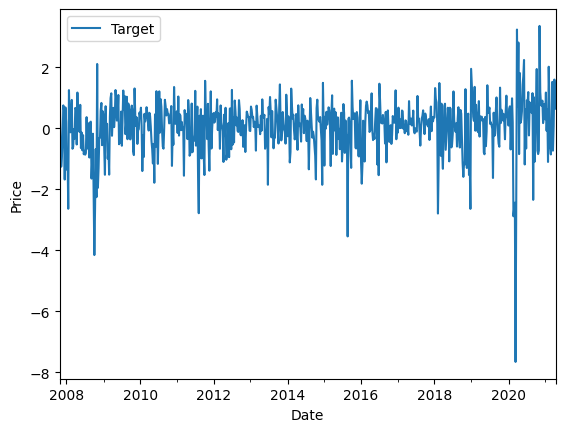

In [5]:
# test the stationarity of the minimum variance portfolio
adf = adfuller(target)
alpha = 0.05
if adf[1] < alpha:
    print('The time series is stationary')
else:
    print('The time series is not stationary')

# we test the stationarity of the minimum variance portfolio using the first
# difference
target_diff = target.diff().dropna()
adf = adfuller(target_diff)
if adf[1] < alpha:
    print('The time series is stationary')
else:
    print('The time series is not stationary')

# graph the minimum variance portfolio differences
target_diff_plot = target_diff.div(target_diff.iloc[0]).plot()
target_diff_plot.set_xlabel('Date')
target_diff_plot.set_ylabel('Price')
target_diff_plot.legend(loc='upper left')
plt.show()

Thus we use the first difference to estimate our model.

## Regressors exploration

### Graph

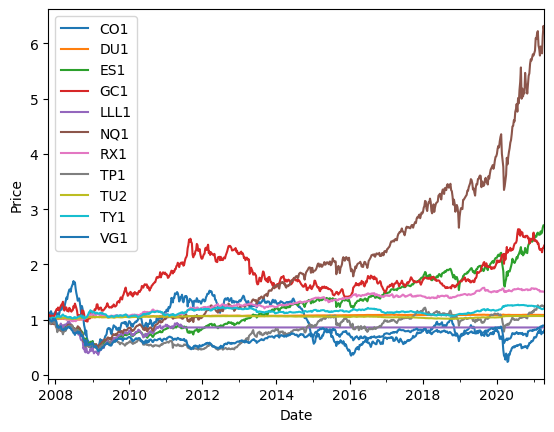

In [6]:
# we plot the futures returns normalized to the first value
futures_plot = futures.div(futures.iloc[0]).plot()
futures_plot.set_xlabel('Date')
futures_plot.set_ylabel('Price')
futures_plot.legend(loc='upper left')
plt.show()

### Covariance matrix

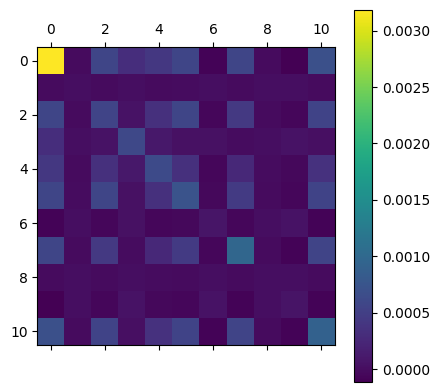

In [7]:
# plot the covariance matrix of the futures
covariance_matrix = futures.pct_change().cov()
covariance_matrix_plot = plt.matshow(covariance_matrix)
plt.colorbar(covariance_matrix_plot)
plt.show()

### Stationarity test

In [8]:
# we test the stationarity of the futures using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
for future in futures:
    result = adfuller(futures[future])
    alpha = 0.05
    if result[1] > alpha:
        print(f'{future} is not stationary')
    else:
        print(f'{future} is stationary')

CO1 is not stationary
DU1 is not stationary
ES1 is not stationary
GC1 is not stationary
LLL1 is stationary
NQ1 is not stationary
RX1 is not stationary
TP1 is not stationary
TU2 is not stationary
TY1 is not stationary
VG1 is stationary


Therefore the series we must accept the null hypothesis of non-stationarity.
The series have at least one unit root.

In [9]:
# we try to stationarize the futures using the first difference
futures_diff = futures.diff().dropna()
for future in futures_diff:
    result = adfuller(futures_diff[future])
    alpha = 0.05
    if result[1] > alpha:
        print(f'{future} is not stationary')
    else:
        print(f'{future} is stationary')


CO1 is stationary
DU1 is stationary
ES1 is stationary
GC1 is stationary
LLL1 is stationary
NQ1 is stationary
RX1 is stationary
TP1 is stationary
TU2 is stationary
TY1 is stationary
VG1 is stationary


Since all the series are now stationary we can proceed with the analysis and accept the null hypothesis of no cointegration.

# ARCH and GARCH models
ARCH and GARCH model are models used when we have evidence for heteroskedasticity.
In particular ARCH stands for **A**uto**R**egressive **C**onditional
**H**eteroskedasticity while GARCH stands for **G**eneralized **ARCH**.  
In practice we estimate target portfolio differences with an OLS method using
the futures differences as regressors:

$$ \Delta y_t = \alpha + \beta \Delta x_t + \epsilon_t $$

where $y_t$ is the target portfolio and $x_t$ is the vector of the regressors.
Then we suppose that the residuals $\epsilon_t$ are of the form:

$$ \epsilon_t \sim \mathcal{N} \left( 0, \sigma_t^2 \right) $$

where $\sigma_t^2$ is the variance of the residuals and that the variance can be
modeled through an AR (ARHC) or ARMA (GARCH) process:

$$ \sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^q \beta_j \sigma_{t-j}^2 $$

where $\omega$ is the constant term, $\alpha_i$ and $\beta_j$ are the coefficients

### OLS model estimation

In [10]:
# we create the OLS model for the minimum variance portfolio using the futures
# as independent variables
ols = LinearRegression()
ols.fit(futures, target)
# print regression summary with p-values
X2 = sm.add_constant(futures)
est = sm.OLS(target, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.523e+04
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        23:00:59   Log-Likelihood:                -2876.8
No. Observations:                 705   AIC:                             5778.
Df Residuals:                     693   BIC:                             5832.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -117.9068     83.470     -1.413      0.1

### ARCH model estimation for the residuals

In [12]:
# create the ARCH model for the minimum variance portfolio
# with the futures as regressors for the mean in a OLS model
am = arch_model(target, x=futures, mean='LS', lags=1, vol='GARCH', p=1, o=0, q=1, dist='Normal')
# fit the model silently
res = am.fit(disp='off')
# print the summary for the mean model
print(res.summary())

                     Least Squares - GARCH Model Results                      
Dep. Variable:                 Target   R-squared:                       0.995
Mean Model:             Least Squares   Adj. R-squared:                  0.995
Vol Model:                      GARCH   Log-Likelihood:               -2730.08
Distribution:                  Normal   AIC:                           5490.15
Method:            Maximum Likelihood   BIC:                           5558.52
                                        No. Observations:                  705
Date:                Sun, May 21 2023   Df Residuals:                      693
Time:                        23:01:16   Df Model:                           12
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const        114.6305    105.876      1.083      0.279 